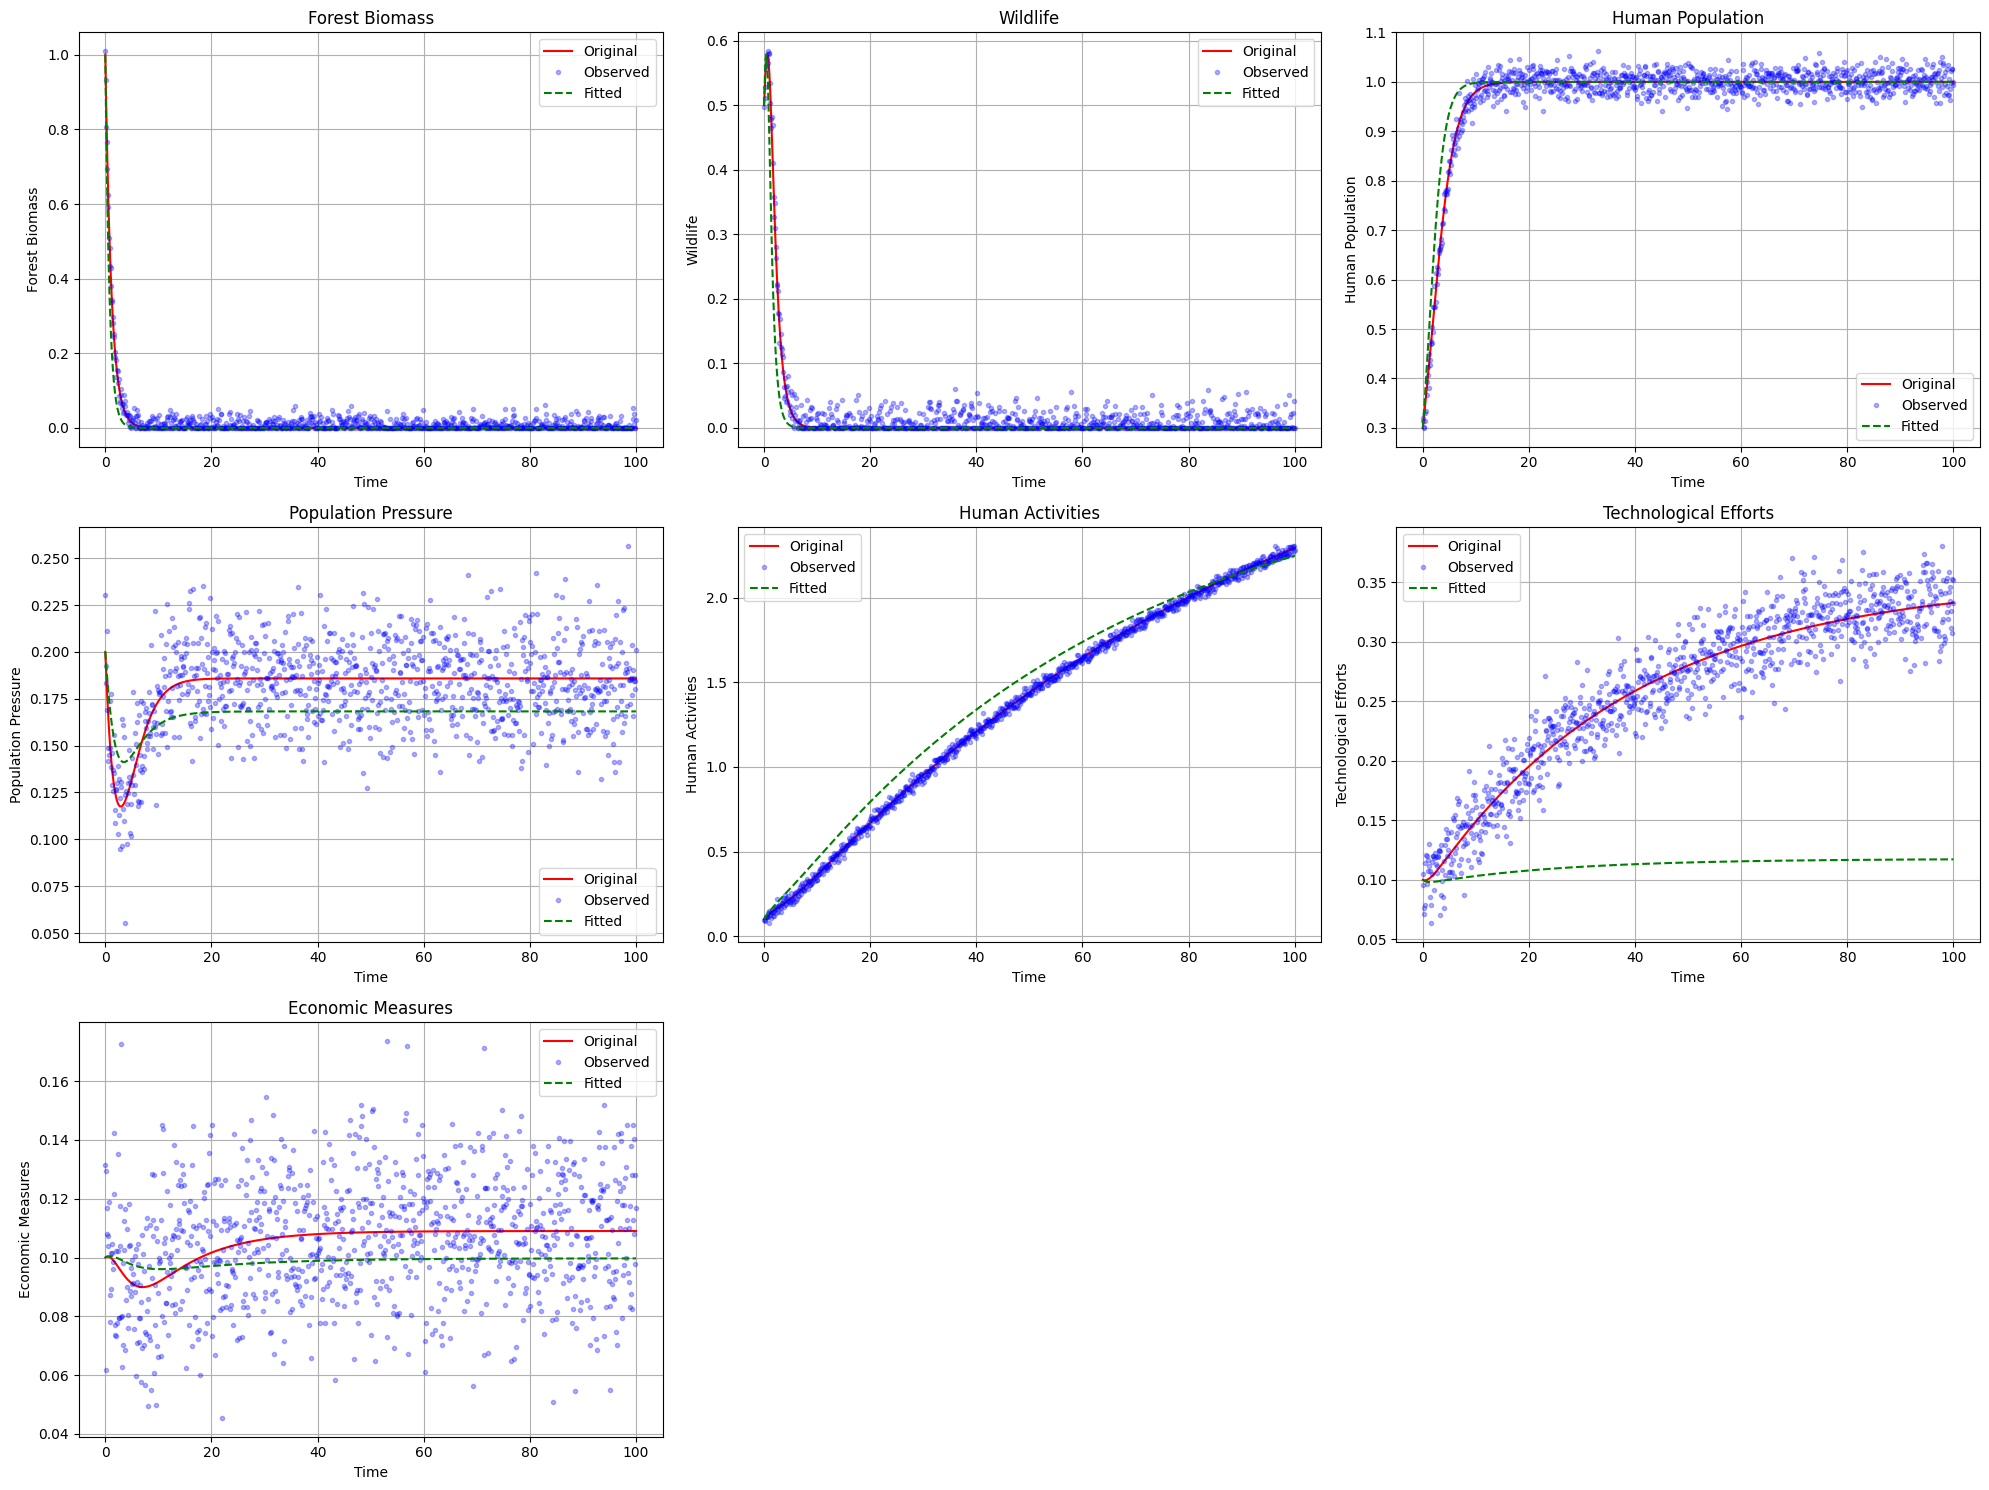


Parameter Comparison:
Parameter | Initial | Fitted
--------------------------------------------------
s        | 0.839737 | 1.259606
alpha    | 0.049309 | 0.073963
beta1    | 0.003194 | 0.004791
beta2    | 0.000461 | 0.000691
rho2     | 0.019532 | 0.009766
r        | 0.878928 | 1.318392
v1       | 0.002316 | 0.003474
v2       | 0.000108 | 0.000162
theta    | 0.476526 | 0.714789
lambda   | 0.052713 | 0.079069
sigma    | 0.000954 | 0.000477
phi      | 0.095343 | 0.047835
phi0     | 0.512098 | 0.283636
phi1     | 0.008087 | 0.006309
gamma    | 0.003310 | 0.001655
pi       | 0.001888 | 0.001036
phi2     | 0.179743 | 0.251561
gamma1   | 0.010314 | 0.015471
rho      | 0.009092 | 0.004546
rho1     | 0.025763 | 0.038645
omega    | 0.057328 | 0.033986
omega1   | 0.097742 | 0.057348


In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def model_forest_biomass(X, t, params):
    """Model with base parameters instead of combined parameters"""
    Y = np.zeros(7)
    
    X = np.maximum(X, np.ones_like(X) * 1e-10)
    
    # Base parameters from table
    s = params[0]      # 0.8
    alpha = params[1]  # 0.05
    beta1 = params[2]  # 0.003
    beta2 = params[3]  # 0.0004
    rho2 = params[4]   # 0.02
    r = params[5]      # 0.9
    v1 = params[6]     # 0.002
    v2 = params[7]     # 0.0001
    theta = params[8]  # 0.5
    lambda_val = params[9]  # 0.05
    sigma = params[10] # 0.001
    phi = params[11]   # 0.1
    phi0 = params[12]  # 0.5
    phi1 = params[13]  # 0.01
    gamma = params[14] # 0.004
    pi_val = params[15] # 0.002
    phi2 = params[16]  # 0.2
    gamma1 = params[17] # 0.01
    rho = params[18]   # 0.01
    rho1 = params[19]  # 0.03
    omega = params[20] # 0.05
    omega1 = params[21] # 0.1
    
    # State variables
    B = X[0]  # Forest Biomass
    W = X[1]  # Wildlife
    N = X[2]  # Human Population
    P = X[3]  # Population Pressure
    H = X[4]  # Human Activities
    T = X[5]  # Technological Efforts
    E = X[6]  # Economic Measures

    # Differential equations using base parameters
    try:
        Y[0] = -s*B - alpha*B*W - beta1*B*N - beta2*(B**2)*H + rho2*B*T
        Y[1] = r*W*(1 - W/B) - v1*W*N - v2*W*H
        Y[2] = theta*N*(1 - N) + lambda_val*beta1*B*N - sigma*N*W
        Y[3] = phi*N - phi0*P - phi1*P*E
        Y[4] = gamma*N + pi_val*beta2*(B**2)*H + phi2*P - gamma1*H
        Y[5] = rho*(1 - B) - rho1*T
        Y[6] = omega*P - omega1*E
    except:
        Y = np.zeros(7)
    
    # Prevent numerical instabilities
    Y = np.clip(Y, -1e3, 1e3)
    return Y

def generate_gaussian_params(n_samples=100):
    """Generate parameters using Gaussian distribution based on table values"""
    np.random.seed(42)
    
    # Parameter values from table
    param_means = [
        0.8,    # s
        0.05,   # alpha
        0.003,  # beta1
        0.0004, # beta2
        0.02,   # rho2
        0.9,    # r
        0.002,  # v1
        0.0001, # v2
        0.5,    # theta
        0.05,   # lambda
        0.001,  # sigma
        0.1,    # phi
        0.5,    # phi0
        0.01,   # phi1
        0.004,  # gamma
        0.002,  # pi
        0.2,    # phi2
        0.01,   # gamma1
        0.01,   # rho
        0.03,   # rho1
        0.05,   # omega
        0.1     # omega1
    ]
    
    param_stds = [mean * 0.1 for mean in param_means]
    
    params_data = np.zeros((n_samples, len(param_means)))
    for i in range(len(param_means)):
        params_data[:, i] = np.maximum(param_means[i] * 0.1, 
                                     np.random.normal(param_means[i], param_stds[i], n_samples))
    
    param_names = [
        's', 'alpha', 'beta1', 'beta2', 'rho2', 'r', 'v1', 'v2', 
        'theta', 'lambda', 'sigma', 'phi', 'phi0', 'phi1', 'gamma',
        'pi', 'phi2', 'gamma1', 'rho', 'rho1', 'omega', 'omega1'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

# Generate synthetic data
t = np.linspace(0, 100, 1000)
X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]

synthetic_params = generate_gaussian_params(n_samples=1)
initial_params = synthetic_params.iloc[0].values

try:
    original_solution = odeint(model_forest_biomass, X0, t, args=(tuple(initial_params),))
except:
    print("Error in generating original solution")
    raise

# Add noise to create observed data
np.random.seed(42)
noise_level = 0.02  
observed_data = original_solution + noise_level * np.random.randn(*original_solution.shape)

# Ensure observed data is positive
observed_data = np.maximum(observed_data, 0)

def objective_function(params, t, observed_data):
    """Objective function for least squares optimization"""
    try:
        solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
        residuals = (solution - observed_data) / (np.abs(observed_data) + 1e-6)
        return residuals.ravel()
    except:
        return np.ones(len(t) * 7) * 1e6

# Define bounds based on table values
lower_bounds = [param * 0.5 for param in initial_params]  # 50% of initial value
upper_bounds = [param * 1.5 for param in initial_params]  # 150% of initial value

# Perform least squares fitting with more robust settings
result = least_squares(objective_function, initial_params, 
                      args=(t, observed_data),
                      bounds=(lower_bounds, upper_bounds),
                      method='trf',
                      ftol=1e-8,
                      xtol=1e-8,
                      gtol=1e-8,
                      max_nfev=1000)

fitted_params = result.x

try:
    fitted_solution = odeint(model_forest_biomass, X0, t, args=(tuple(fitted_params),))
except:
    print("Error in generating fitted solution")
    raise

# Plot results
variables = [
    'Forest Biomass', 'Wildlife', 'Human Population', 
    'Population Pressure', 'Human Activities',
    'Technological Efforts', 'Economic Measures'
]

plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(3, 3, i+1)
    plt.plot(t, original_solution[:, i], 'r-', label='Original')
    plt.plot(t, observed_data[:, i], 'b.', label='Observed', alpha=0.3)
    plt.plot(t, fitted_solution[:, i], 'g--', label='Fitted')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.title(f'{variables[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print parameter comparison
param_names = [
    's', 'alpha', 'beta1', 'beta2', 'rho2', 'r', 'v1', 'v2', 
    'theta', 'lambda', 'sigma', 'phi', 'phi0', 'phi1', 'gamma',
    'pi', 'phi2', 'gamma1', 'rho', 'rho1', 'omega', 'omega1'
]

print("\nParameter Comparison:")
print("Parameter | Initial | Fitted")
print("-" * 50)
for name, init, fit in zip(param_names, initial_params, fitted_params):
    print(f"{name:8} | {init:8.6f} | {fit:8.6f}")

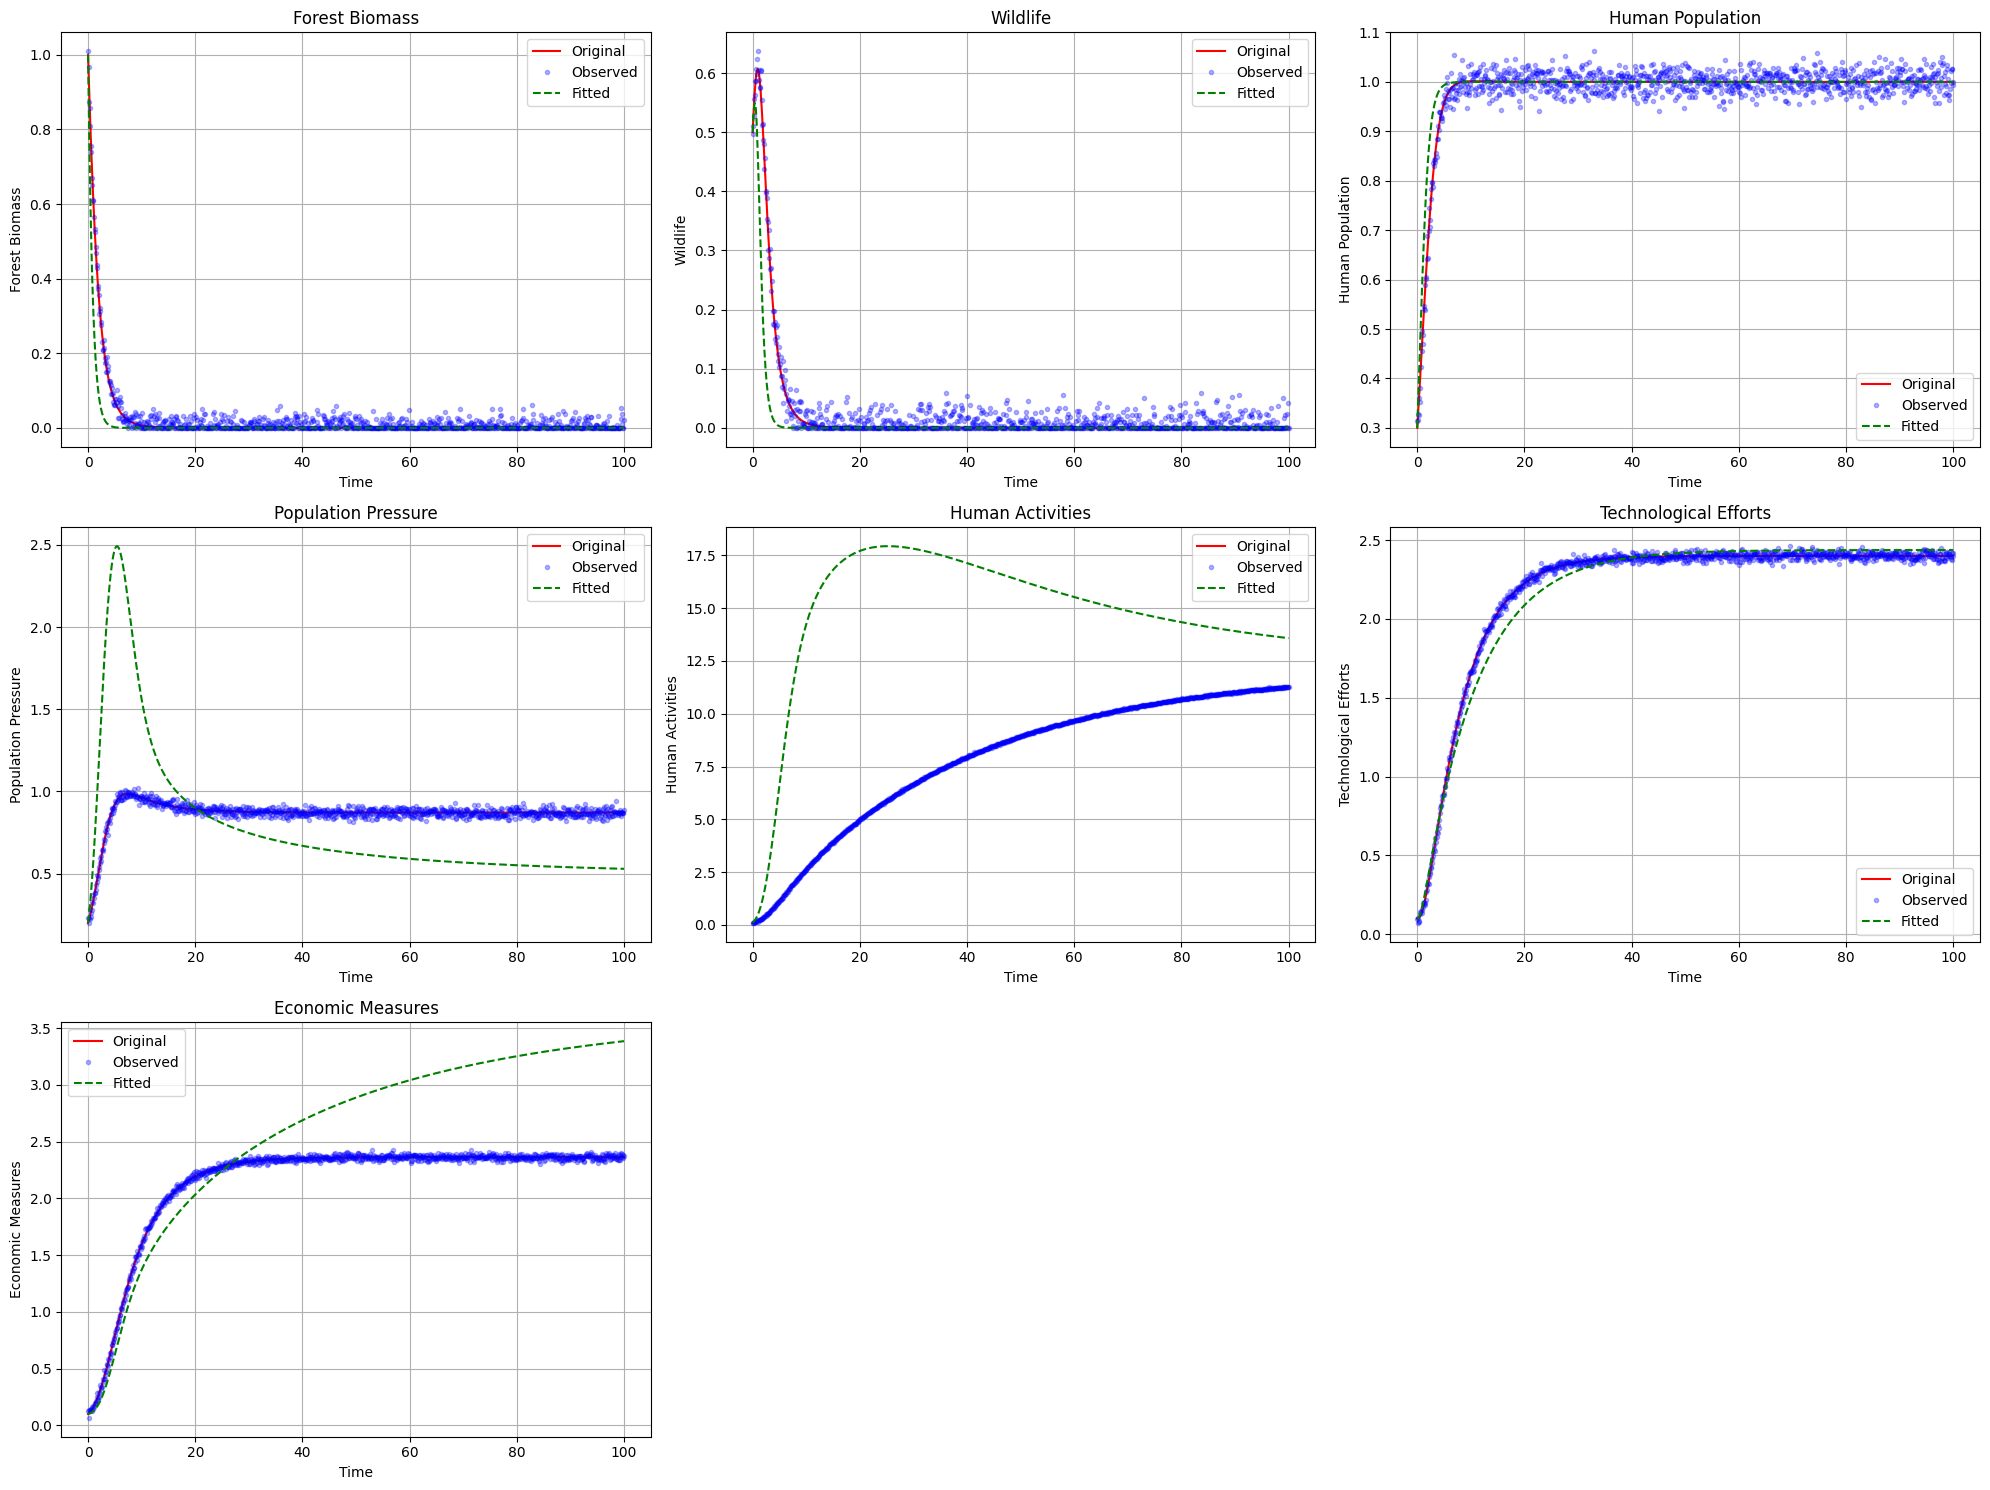


Parameter Comparison:
Parameter | Initial | Fitted | Range
------------------------------------------------------------
s        | 0.380795 | 1.000000 | [0.010000, 1.000000]
alpha    | 0.085569 | 0.090000 | [0.000100, 0.090000]
beta1    | 0.219625 | 0.300000 | [0.000100, 0.300000]
beta2    | 0.024147 | 0.040000 | [0.000500, 0.040000]
rho2     | 0.093696 | 0.000100 | [0.000100, 0.600000]
r        | 0.834997 | 1.000000 | [0.804500, 1.000000]
v1       | 0.011805 | 0.200000 | [0.000200, 0.200000]
v2       | 0.086620 | 0.100000 | [0.000020, 0.100000]
theta    | 0.605104 | 1.000000 | [0.010000, 1.000000]
lambda   | 0.708073 | 1.000000 | [0.000000, 1.000000]
sigma    | 0.003038 | 0.001000 | [0.001000, 0.100000]
phi      | 0.873220 | 0.900000 | [0.010000, 0.900000]
phi0     | 0.750874 | 0.010000 | [0.010000, 0.900000]
phi1     | 0.106248 | 0.500000 | [0.000100, 0.500000]
gamma    | 0.072812 | 0.173679 | [0.000100, 0.400000]
pi       | 0.183405 | 1.000000 | [0.000000, 1.000000]
phi2     | 0.28

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def model_forest_biomass(X, t, params):
    """Model with base parameters instead of combined parameters"""
    Y = np.zeros(7)
    
    X = np.maximum(X, np.ones_like(X) * 1e-10)
    
    # Base parameters from table A.2
    s = params[0]      # Natural decay rate
    alpha = params[1]  # Impact of wildlife
    beta1 = params[2]  # Human population impact
    beta2 = params[3]  # Human activities impact
    rho2 = params[4]   # Technology impact on biomass
    r = params[5]      # Wildlife growth rate
    v1 = params[6]     # Human impact on wildlife
    v2 = params[7]     # Activity impact on wildlife
    theta = params[8]  # Human population growth
    lambda_val = params[9]  # Resource availability
    sigma = params[10] # Wildlife impact on humans
    phi = params[11]   # Population pressure growth
    phi0 = params[12]  # Natural decay of pressure
    phi1 = params[13]  # Economic impact on pressure
    gamma = params[14] # Human activities growth
    pi_val = params[15] # Resource conversion rate
    phi2 = params[16]  # Pressure impact on activities
    gamma1 = params[17] # Activities decay rate
    rho = params[18]   # Technology growth rate
    rho1 = params[19]  # Technology decay rate
    omega = params[20] # Economic growth rate
    omega1 = params[21] # Economic decay rate
    
    # State variables
    B = X[0]  # Forest Biomass
    W = X[1]  # Wildlife
    N = X[2]  # Human Population
    P = X[3]  # Population Pressure
    H = X[4]  # Human Activities
    T = X[5]  # Technological Efforts
    E = X[6]  # Economic Measures

    # Differential equations using base parameters
    try:
        Y[0] = -s*B - alpha*B*W - beta1*B*N - beta2*(B**2)*H + rho2*B*T
        Y[1] = r*W*(1 - W/B) - v1*W*N - v2*W*H
        Y[2] = theta*N*(1 - N) + lambda_val*beta1*B*N - sigma*N*W
        Y[3] = phi*N - phi0*P - phi1*P*E
        Y[4] = gamma*N + pi_val*beta2*(B**2)*H + phi2*P - gamma1*H
        Y[5] = rho*(1 - B) - rho1*T
        Y[6] = omega*P - omega1*E
    except:
        Y = np.zeros(7)
    
    # Prevent numerical instabilities
    Y = np.clip(Y, -1e3, 1e3)
    return Y

def generate_uniform_params(n_samples=100):
    """Generate parameters using uniform distribution based on table A.2 values"""
    np.random.seed(42)
    
    param_ranges = [
        (0.01, 1.0),      # s      - Natural decay rate
        (0.0001, 0.09),   # alpha  - Impact of wildlife
        (0.0001, 0.3),    # beta1  - Human population impact
        (0.0005, 0.04),   # beta2  - Human activities impact
        (0.0001, 0.6),    # rho2   - Technology impact on biomass
        (0.8045, 1.0),    # r      - Wildlife growth rate (using eta)
        (0.0002, 0.2),    # v1     - Human impact on wildlife
        (0.00002, 0.1),   # v2     - Activity impact on wildlife
        (0.01, 1.0),      # theta  - Human population growth
        (0.0, 1.0),       # lambda - Resource availability
        (0.001, 0.1),     # sigma  - Wildlife impact on humans
        (0.01, 0.9),      # phi    - Population pressure growth
        (0.01, 0.9),      # phi0   - Natural decay of pressure
        (0.0001, 0.5),    # phi1   - Economic impact on pressure
        (0.0001, 0.4),    # gamma  - Human activities growth
        (0.0, 1.0),       # pi     - Resource conversion rate
        (0.02, 0.9),      # phi2   - Pressure impact on activities
        (0.001, 0.05),    # gamma1 - Activities decay rate
        (0.01, 0.8),      # rho    - Technology growth rate
        (0.001, 0.5),     # rho1   - Technology decay rate
        (0.01, 0.5),      # omega  - Economic growth rate
        (0.003, 0.8)      # omega1 - Economic decay rate
    ]
    
    param_means = [
        0.69,    # s
        0.0487,  # alpha
        0.0029,  # beta1
        0.0004,  # beta2
        0.0215,  # rho2
        0.8045,  # r (using eta)
        0.002,   # v1
        0.0001,  # v2
        0.75,    # theta
        0.045,   # lambda
        0.0012,  # sigma
        0.09,    # phi
        0.4323,  # phi0
        0.011,   # phi1
        0.0039,  # gamma
        0.023,   # pi
        0.18,    # phi2
        0.0429,  # gamma1
        0.028,   # rho
        0.0738,  # rho1
        0.0524,  # omega
        0.1067   # omega1
    ]
    
    params_data = np.zeros((n_samples, len(param_ranges)))
    for i, ((min_val, max_val), mean_val) in enumerate(zip(param_ranges, param_means)):
        params_data[:, i] = np.random.uniform(min_val, max_val, n_samples)
    
    param_names = [
        's', 'alpha', 'beta1', 'beta2', 'rho2', 'r', 'v1', 'v2', 
        'theta', 'lambda', 'sigma', 'phi', 'phi0', 'phi1', 'gamma',
        'pi', 'phi2', 'gamma1', 'rho', 'rho1', 'omega', 'omega1'
    ]
    
    return pd.DataFrame(params_data, columns=param_names), param_ranges, param_means

def objective_function(params, t, observed_data):
    """Objective function for least squares optimization"""
    try:
        solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
        residuals = (solution - observed_data) / (np.abs(observed_data) + 1e-6)
        return residuals.ravel()
    except:
        return np.ones(len(t) * 7) * 1e6

# Set up simulation parameters
t = np.linspace(0, 100, 1000)
X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1] #ini value B,W,N,P,H,T,E

# Generate parameters and create synthetic data
uniform_params, param_ranges, param_means = generate_uniform_params(n_samples=1)
initial_params = uniform_params.iloc[0].values

try:
    original_solution = odeint(model_forest_biomass, X0, t, args=(tuple(initial_params),))
except:
    print("Error in generating original solution")
    raise

# Add noise to create observed data
np.random.seed(42)
noise_level = 0.02
observed_data = original_solution + noise_level * np.random.randn(*original_solution.shape)
observed_data = np.maximum(observed_data, 0)

# Define bounds for optimization
lower_bounds = [range[0] for range in param_ranges]
upper_bounds = [range[1] for range in param_ranges]

# Perform least squares fitting
result = least_squares(objective_function, 
                      initial_params, 
                      args=(t, observed_data),
                      bounds=(lower_bounds, upper_bounds),
                      method='trf',
                      ftol=1e-8,
                      xtol=1e-8,
                      gtol=1e-8,
                      max_nfev=1000)

fitted_params = result.x

# Generate fitted solution
try:
    fitted_solution = odeint(model_forest_biomass, X0, t, args=(tuple(fitted_params),))
except:
    print("Error in generating fitted solution")
    raise

# Plot results
variables = [
    'Forest Biomass', 'Wildlife', 'Human Population', 
    'Population Pressure', 'Human Activities',
    'Technological Efforts', 'Economic Measures'
]

plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(3, 3, i+1)
    plt.plot(t, original_solution[:, i], 'r-', label='Original')
    plt.plot(t, observed_data[:, i], 'b.', label='Observed', alpha=0.3)
    plt.plot(t, fitted_solution[:, i], 'g--', label='Fitted')
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.title(f'{variables[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print parameter comparison
param_names = [
    's', 'alpha', 'beta1', 'beta2', 'rho2', 'r', 'v1', 'v2', 
    'theta', 'lambda', 'sigma', 'phi', 'phi0', 'phi1', 'gamma',
    'pi', 'phi2', 'gamma1', 'rho', 'rho1', 'omega', 'omega1'
]

print("\nParameter Comparison:")
print("Parameter | Initial | Fitted | Range")
print("-" * 60)
for name, init, fit, (min_val, max_val) in zip(param_names, initial_params, fitted_params, param_ranges):
    print(f"{name:8} | {init:8.6f} | {fit:8.6f} | [{min_val:8.6f}, {max_val:8.6f}]")

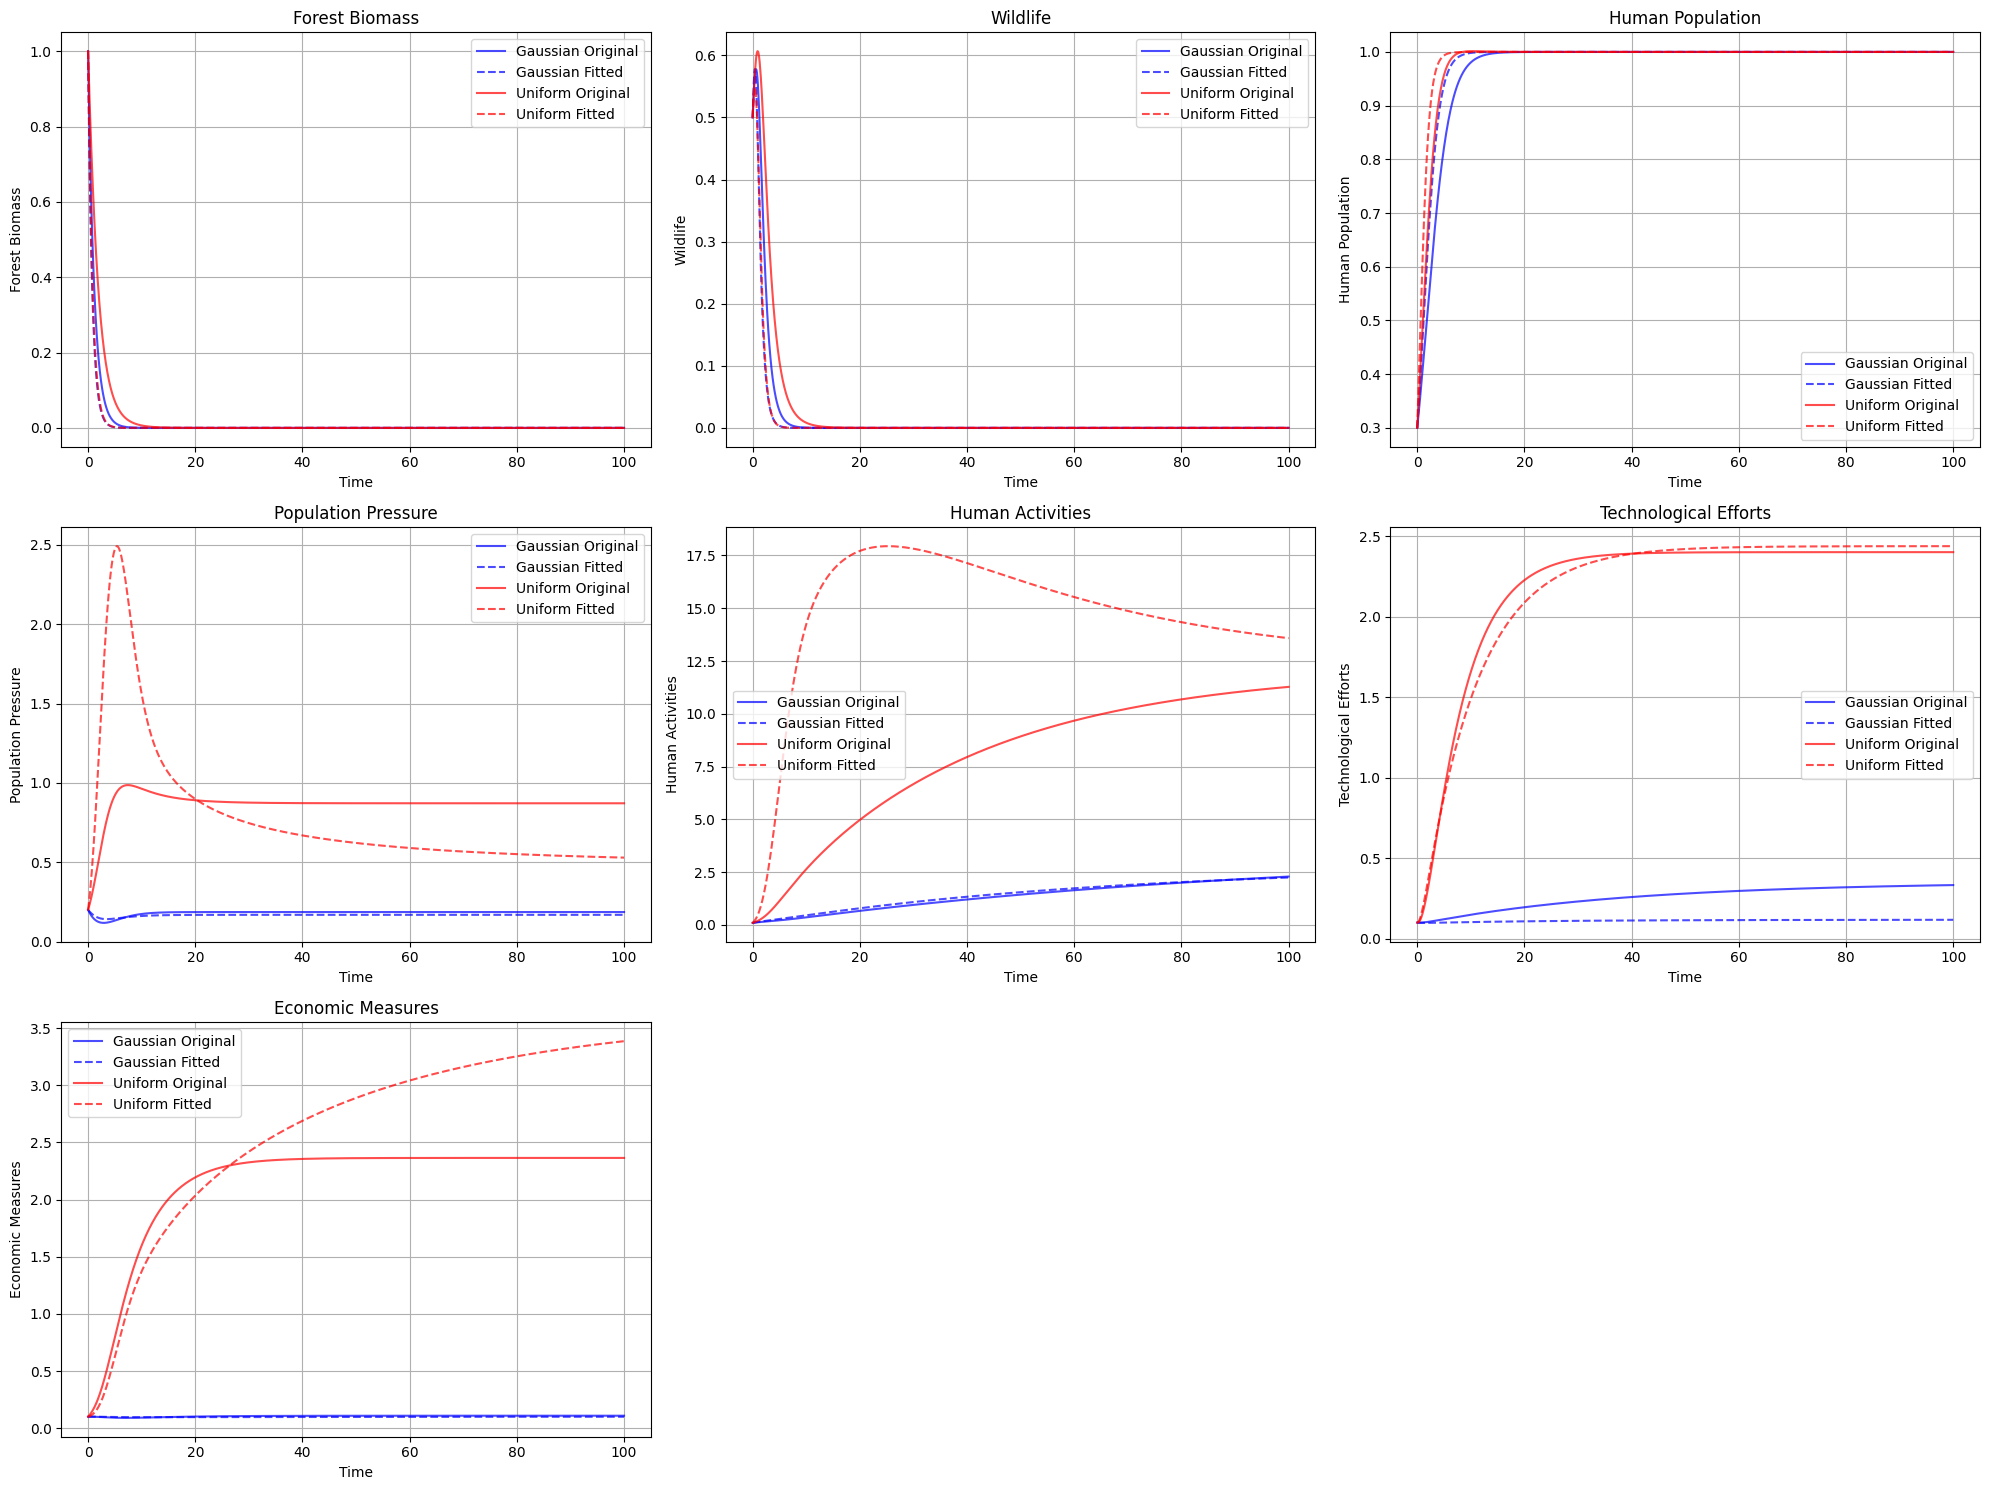


Rata-rata perbedaan parameter untuk setiap metode:
Method
Gaussian    0.072740
Uniform     0.230791
Name: Difference, dtype: float64

Parameter dengan perbedaan terbesar:
      Method Parameter  Difference
37   Uniform        pi    0.816595
34   Uniform      phi0    0.740874
22   Uniform         s    0.619205
38   Uniform      phi2    0.612267
5   Gaussian         r    0.439464


In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import os

def run_comparison(n_samples=100, save_path="results"):
    # Membuat direktori untuk menyimpan hasil jika belum ada
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Set parameter simulasi
    t = np.linspace(0, 100, 1000)
    X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
    
    # Generate parameter menggunakan kedua metode
    gaussian_params = generate_gaussian_params(n_samples=1)
    uniform_params, param_ranges, param_means = generate_uniform_params(n_samples=1)
    
    # Simpan parameter awal ke CSV
    gaussian_params.to_csv(f"{save_path}/gaussian_parameters.csv", index=False)
    uniform_params.to_csv(f"{save_path}/uniform_parameters.csv", index=False)
    
    # Jalankan simulasi untuk kedua metode
    results = {}
    for method, params in [("Gaussian", gaussian_params.iloc[0].values), 
                          ("Uniform", uniform_params.iloc[0].values)]:
        try:
            # Generate solusi original
            original_solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
            
            # Tambahkan noise
            np.random.seed(42)  # Untuk konsistensi
            noise_level = 0.02
            observed_data = original_solution + noise_level * np.random.randn(*original_solution.shape)
            observed_data = np.maximum(observed_data, 0)
            
            # Simpan data synthetic ke CSV
            variables = ['Forest_Biomass', 'Wildlife', 'Human_Population', 
                        'Population_Pressure', 'Human_Activities',
                        'Technological_Efforts', 'Economic_Measures']
            
            # Menyimpan data original
            df_original = pd.DataFrame(original_solution, columns=variables)
            df_original['time'] = t
            df_original.to_csv(f"{save_path}/{method.lower()}_original_data.csv", index=False)
            
            # Menyimpan data observed (dengan noise)
            df_observed = pd.DataFrame(observed_data, columns=variables)
            df_observed['time'] = t
            df_observed.to_csv(f"{save_path}/{method.lower()}_observed_data.csv", index=False)
            
            # Lakukan fitting
            if method == "Gaussian":
                lower_bounds = [param * 0.5 for param in params]
                upper_bounds = [param * 1.5 for param in params]
            else:
                lower_bounds = [range[0] for range in param_ranges]
                upper_bounds = [range[1] for range in param_ranges]
            
            result = least_squares(objective_function, 
                                 params,
                                 args=(t, observed_data),
                                 bounds=(lower_bounds, upper_bounds),
                                 method='trf',
                                 ftol=1e-8,
                                 xtol=1e-8,
                                 gtol=1e-8,
                                 max_nfev=1000)
            
            fitted_params = result.x
            fitted_solution = odeint(model_forest_biomass, X0, t, args=(tuple(fitted_params),))
            
            # Simpan data fitted
            df_fitted = pd.DataFrame(fitted_solution, columns=variables)
            df_fitted['time'] = t
            df_fitted.to_csv(f"{save_path}/{method.lower()}_fitted_data.csv", index=False)
            
            results[method] = {
                'original': original_solution,
                'observed': observed_data,
                'fitted': fitted_solution,
                'initial_params': params,
                'fitted_params': fitted_params
            }
            
        except Exception as e:
            print(f"Error in {method} method: {str(e)}")
            continue
    
    # Plot perbandingan
    variables = [
        'Forest Biomass', 'Wildlife', 'Human Population', 
        'Population Pressure', 'Human Activities',
        'Technological Efforts', 'Economic Measures'
    ]
    
    fig = plt.figure(figsize=(20, 15))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        
        for method, style_dict in [
            ("Gaussian", {'orig_color': 'b', 'fit_color': 'b', 'fit_style': '--'}),
            ("Uniform", {'orig_color': 'r', 'fit_color': 'r', 'fit_style': '--'})
        ]:
            if method in results:
                plt.plot(t, results[method]['original'][:, i], 
                        color=style_dict['orig_color'],
                        label=f'{method} Original', 
                        alpha=0.7)
                plt.plot(t, results[method]['fitted'][:, i], 
                        color=style_dict['fit_color'],
                        linestyle=style_dict['fit_style'],
                        label=f'{method} Fitted', 
                        alpha=0.7)
        
        plt.xlabel('Time')
        plt.ylabel(variables[i])
        plt.title(f'{variables[i]}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    
    # Tampilkan plot
    plt.show()
    
    # Simpan plot
    fig.savefig(f"{save_path}/comparison_plot.png")
    plt.close()
    
    # Print parameter comparison
    param_names = [
        's', 'alpha', 'beta1', 'beta2', 'rho2', 'r', 'v1', 'v2', 
        'theta', 'lambda', 'sigma', 'phi', 'phi0', 'phi1', 'gamma',
        'pi', 'phi2', 'gamma1', 'rho', 'rho1', 'omega', 'omega1'
    ]
    
    # Buat DataFrame untuk perbandingan parameter
    comparison_data = []
    for method in results:
        for name, init, fit in zip(param_names, 
                                 results[method]['initial_params'],
                                 results[method]['fitted_params']):
            comparison_data.append({
                'Method': method,
                'Parameter': name,
                'Initial': init,
                'Fitted': fit,
                'Difference': abs(fit - init)
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv(f"{save_path}/parameter_comparison.csv", index=False)
    
    return results, comparison_df

# Jalankan perbandingan
results, comparison_df = run_comparison(save_path="simulation_results")

# Tampilkan beberapa statistik perbandingan
print("\nRata-rata perbedaan parameter untuk setiap metode:")
print(comparison_df.groupby('Method')['Difference'].mean())
print("\nParameter dengan perbedaan terbesar:")
print(comparison_df.nlargest(5, 'Difference')[['Method', 'Parameter', 'Difference']])